# Expected time required to run the entire notebook: ~1h 45min
## Team members: D'ANGELO Stefano, TANCZOS Akos

# 1. Dataset exploration

## a. Modules import

In [1]:
# statistics
from scipy.stats import ttest_ind

# models
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Conv3D, MaxPooling3D, Dropout
from tensorflow.keras.models import Model

# metrics and model selection
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, label_binarize
from keras.callbacks import EarlyStopping

# other
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import FileLink
from keras.backend import clear_session
import itertools, time, os

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

## b. Data loading

In [2]:
n_datasets = 15
train_datasets = {}
test_datasets = {}
BASE_DIR = "/kaggle/input/smemi309-final-evaluation-challenge-2021"

train_datasets[1] = pd.read_csv(os.path.join(BASE_DIR, "train" + str(1) + "slice.csv"))
test_datasets[1] = pd.read_csv(os.path.join(BASE_DIR, "test" + str(1) + "slice.csv"))

for i in range(2, n_datasets+1):
    train_datasets[i] = pd.read_csv(os.path.join(BASE_DIR, "train" + str(i) + "slices.csv"))
    test_datasets[i] = pd.read_csv(os.path.join(BASE_DIR, "test" + str(i) + "slices.csv"))

In [3]:
main_ds = 5
main_train_df = train_datasets[main_ds]
main_test_df = test_datasets[main_ds]

In [4]:
main_train_df

,label,0,1,2,3,4,5,6,7,8,...,310,311,312,313,314,315,316,317,318,319
0,5,0.0124,0.0098,0.0126,0.0196,0.0301,0.0373,0.0332,0.0185,0.0110,...,0.1839,0.0326,0.0049,0.0059,0.0100,0.0210,0.0529,0.0856,0.0398,0.0293
1,4,0.0138,0.0105,0.0167,0.0131,0.0154,0.0490,0.1293,0.1088,0.0089,...,0.1430,0.1188,0.0039,0.0126,0.0146,0.0140,0.0193,0.0196,0.0337,0.0218
2,6,0.0131,0.0053,0.0047,0.0125,0.0126,0.0259,0.0358,0.0170,0.0132,...,0.0582,0.0462,0.0213,0.3641,0.7799,0.7864,0.4691,0.0696,0.0237,0.0210
3,7,0.0013,0.0023,0.0063,0.0046,0.0109,0.0229,0.0281,0.0076,0.0029,...,0.0370,0.0166,0.0026,0.0088,0.0083,0.0123,0.0079,0.0099,0.0135,0.0089
4,3,0.0045,0.0482,0.0606,0.0809,0.0751,0.0182,0.0287,0.0196,0.0165,...,0.1818,0.2204,0.0095,0.0087,0.0111,0.0159,0.0191,0.0355,0.0548,0.0511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1072,0,0.0013,0.0035,0.0011,0.0045,0.0036,0.0056,0.0019,0.0027,0.0019,...,0.0019,0.0017,0.0010,0.0011,0.0032,0.0124,0.0069,0.0089,0.0018,0.0022
1073,1,0.0000,0.0019,0.0073,0.0051,0.0052,0.0015,0.0018,0.0001,0.0000,...,0.0031,0.0005,0.0000,0.0000,0.0006,0.0008,0.0008,0.0002,0.0029,0.0010
1074,9,0.0101,0.0057,0.0026,0.0028,0.0049,0.0102,0.0077,0.0110,0.0036,...,0.0194,0.0087,0.0044,0.0020,0.0033,0.0019,0.0048,0.0079,0.0083,0.0068
1075,8,0.0042,0.0028,0.0033,0.0031,0.0059,0.0119,0.0066,0.0036,0.0034,...,0.0106,0.0032,0.0026,0.0009,0.0025,0.0037,0.0019,0.0020,0.0137,0.0079


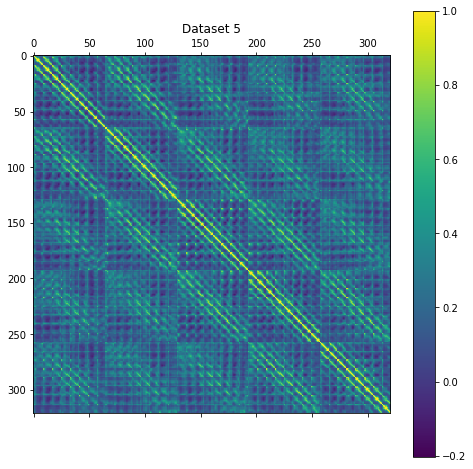

In [5]:
# See data correlation
plt.figure(figsize=(8,8))
plt.matshow(main_train_df.corr(), fignum=1)
plt.title('Dataset ' + str(main_ds));
plt.colorbar()
plt.show()

This plot is kind of divided into a 5x5 symmetric matrix. Each square represents then the correlation between two different slices, which is higher along the main diagonal. Also, each pixel in one slice is more correlated to its neighbor pixels, while each slice is more correlated to the slice immediately before and/or immediately after it. However, this correlation exists only among pixels in the same area in both the slices. For example, pixel at position (0,0) in first slice is highly correlated with:
* its own neighbors
* pixel at position (0,0), and its neighbors, in second slice

In [6]:
data = main_train_df.iloc[:, 1:]
labels = main_train_df.label
n_classes = len(np.unique(labels))
n_features = main_train_df.shape[1] - 1

# 2. Choice of the model

## a. Helper methods definition

### General models methods

In [7]:
def split_dataset(data, labels, val_split=0.1):
    return train_test_split(data, labels, test_size=val_split, random_state=1234, shuffle=True, stratify=labels)

def cross_validate(model, K, data, labels):
    train_accuracy = 0
    valid_accuracy = 0
    results = []
    for fold, indices in enumerate(stratified_fold.split(data, labels)):

        X_train, y_train = data.loc[indices[0], :], labels[indices[0]]
        X_valid, y_valid = data.loc[indices[1], :], labels[indices[1]]
        
        model.fit(X_train, y_train)
        
        acc_t = accuracy_score(y_train, model.predict(X_train))
        acc_v = accuracy_score(y_valid, model.predict(X_valid))
        
        train_accuracy += acc_t
        valid_accuracy += acc_v
        
        results.append(acc_v)
    
    return y_valid.values, model.predict(X_valid), np.array(results)

### Neural Network methods

In [8]:
def reshape_df(df, new_shape):
    return np.reshape(df.to_numpy(), new_shape)

def dataframe_to_images(train_df, n_slices, n_features, test_df=None, width=8, preserve_shape=False):
    train_samples = train_df.shape[0]
    
    if preserve_shape:
        train_images = reshape_df(train_df.drop("label", 1), (train_samples, n_slices, width, width, 1))
    else:
        train_images = reshape_df(train_df.drop("label", 1).iloc[:, :n_features], (train_samples, n_slices, width, width, 1))
    
    if test_df is not None:
        test_samples = test_df.shape[0]
        test_images = reshape_df(test_df, (test_samples, n_slices, width, width, 1))
    else:
        test_images = None
     
    return train_images, test_images

def build_model(input_shape, n_classes):
    clear_session()
    
    img_input = Input(shape=input_shape)
    
    # Block 1
    x = Conv3D(64, 3,
               activation='relu',
               padding='same',
               name='block1_conv1')(img_input)
    x = Dropout(.5)(x)
    x = Conv3D(64, 3,
               activation='relu',
               padding='same',
               name='block1_conv2')(x)
    x = Dropout(.5)(x)
    
    # We check if there are enough slices to reduce image size or not
    if input_shape[0] < 2:
        x = MaxPooling3D(2, strides=2, padding='same', name='block1_pool')(x)
    else:
        x = MaxPooling3D(2, strides=2, name='block1_pool')(x)
    
    # FC network
    x = Flatten(name='flatten')(x)
    x = Dropout(.4)(x)
    x = Dense(256, activation='relu', name='fc')(x)
    x = Dropout(.4)(x)
    x = Dense(11, activation='softmax', name='predictions')(x)
    
    model = Model(img_input, x, name='CNN3D')
    
    return model

def train_model(model, train_data, valid_data, optimizer, callbacks, bs=128, epochs=200, verbose=False, print_summary=False):
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    if print_summary:
        print(model.summary())
        
    # Train the model
    history = model.fit(train_data[0], 
                        train_data[1],
                        batch_size=bs,
                        epochs=epochs,
                        verbose=verbose,
                        validation_data=valid_data,
                        callbacks=callbacks)
    
    return history

def cross_validate_nn(data, labels, input_shape, n_classes, optimizer, K, bs=128, epochs=200, verbose=False, patience=20):
    stratified_fold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1234)
    train_accuracy = 0
    valid_accuracy = 0
    best_accuracy = 0
    results = []
    
    for fold, indices in enumerate(stratified_fold.split(data, labels)):

        X_train, y_train = data[indices[0]], labels[indices[0]]
        X_valid, y_valid = data[indices[1]], labels[indices[1]]
        
        early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=patience, restore_best_weights=False)

        # Build the model
        model = build_model(input_shape, n_classes)

        # Train the model
        history = train_model(model=model, 
                              train_data=(X_train, y_train),
                              valid_data=(X_valid, y_valid),
                              optimizer=optimizer, 
                              callbacks=[early_stopping],
                              bs=bs,
                              epochs=epochs,
                              verbose=verbose,
                              print_summary=False)

        print("Results of fold {}\n".format(fold+1))
        acc_t = history.history['accuracy'][-early_stopping.patience]
        acc_v = history.history['val_accuracy'][-early_stopping.patience]

        print("Best accuracy on training: {:.2f}".format(acc_t))
        print("Best accuracy on validation: {:.2f}\n\n".format(acc_v))

        train_accuracy += acc_t
        valid_accuracy += acc_v
        
        results.append(acc_v)
        
        if acc_v > best_accuracy:
            best_accuracy = acc_v
            best_split = (X_train, y_train, X_valid, y_valid)

    print("\n\nCross-Validation Accuracy on Training:", train_accuracy/K)
    print("Cross-Validation Accuracy on Validation:", valid_accuracy/K)
    
    print("\nBest Cross-Validated Accuracy on Validation:", best_accuracy)
    
    y_pred = model.predict(best_split[-2]) # compute the predictions on the validation set of the best split
    y_pred = np.argmax(y_pred, axis=1)
    
    return best_split[-1], y_pred, np.array(results)

def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy over epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch no.')
    plt.legend(['training', 'validation'])
    plt.show()
    
    return 

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss over epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch no.')
    plt.legend(['training', 'validation'])
    plt.show()

## b. Analysis of different models
In this section, we analyse different models following a procedure consisting of these steps:
1. **Models analysis**:
    * We group models in different categories: 
         - Ensemble models
         - Linear models
         - Non-Linear models 
         - Other models
         
      Each model in this section is trained using Stratified K-fold Cross-Validation
2. **Models comparison**:
    * We analyse each model in three ways:
         - ROC curves plots
         - Confusion Matrices plot
         - Accuracies plots
3. **Conclusions**

In [9]:
K=10
stratified_fold = StratifiedKFold(n_splits=K, shuffle=True, random_state=1234)
all_models = []
results = []

### 1. Models analysis

#### Ensemble models : RandomForestClassifier, AdaBoostClassifier, Baggingclassifier

In [10]:
models = [RandomForestClassifier(), AdaBoostClassifier(), BaggingClassifier()]
all_models.append(models)

for model in models:
    res = cross_validate(model=model, K=K, data=data, labels=labels)
    results.append(res)
    
    print("Trained model:", type(model).__name__)

Trained model: RandomForestClassifier
Trained model: AdaBoostClassifier
Trained model: BaggingClassifier


#### Linear models: LogisticRegression

In [11]:
models = [LogisticRegression()]
all_models.append(models)

for model in models:
    res = cross_validate(model=model, K=K, data=data, labels=labels)
    results.append(res)
    
    print("Trained model:", type(model).__name__)

Trained model: LogisticRegression


#### Non-Linear models: SVC, KNeighborsClassifier, MLPClassifier, DecisionTreeClassifier

In [12]:
models = [SVC(), KNeighborsClassifier(), MLPClassifier(), DecisionTreeClassifier()]
all_models.append(models)

for model in models:
    res = cross_validate(model=model, K=K, data=data, labels=labels)
    results.append(res)
    
    print("Trained model:", type(model).__name__)

Trained model: SVC
Trained model: KNeighborsClassifier
Trained model: MLPClassifier
Trained model: DecisionTreeClassifier


#### Other models: CNN3D
In order to feed the training samples to a 3D Convolutional Neural Network, we must reshape the samples as images.

##### Data preprocessing

In [13]:
train_images, test_images = dataframe_to_images(main_train_df, n_slices=main_ds, n_features=n_features, test_df=main_test_df)

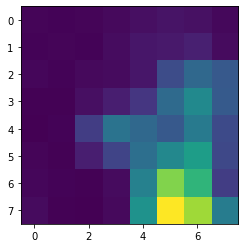

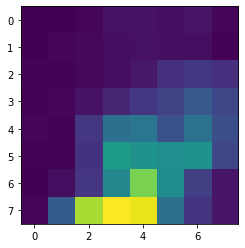

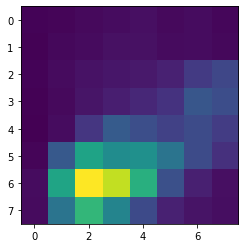

In [14]:
# Show few samples
for i in range(3):
    plt.imshow(train_images[0][i])
    plt.show()

##### Model training

In [15]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)
BS = 128
PATIENCE = 20
EPOCHS = 200
input_shape = train_images.shape[1:]

In [16]:
res = cross_validate_nn(data=train_images, 
                        labels=labels.values,
                        input_shape=input_shape,
                        n_classes=n_classes,
                        optimizer=optimizer, 
                        K=K, 
                        bs=BS, 
                        epochs=EPOCHS, 
                        verbose=False,
                        patience=PATIENCE)


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 00094: early stopping
Results of fold 1

Best accuracy on training: 0.90
Best accuracy on validation: 0.86


Epoch 00076: early stopping
Results of fold 2

Best accuracy on training: 0.92
Best accuracy on validation: 0.84


Epoch 00074: early stopping
Results of fold 3

Best accuracy on training: 0.93
Best accuracy on validation: 0.87


Epoch 00096: early stopping
Results of fold 4

Best accuracy on training: 0.94
Best accuracy on validation: 0.84


Epoch 00083: early stopping
Results of fold 5

Best accuracy on training: 0.93
Best accuracy on validation: 0.84


Epoch 00058: early stopping
Results of fold 6

Best accuracy on training: 0.91
Best accuracy on validation: 0.80


Epoch 00087: early stopping
Results of fold 7

Best accuracy on training: 0.93
Best accuracy on validation: 0.84


Epoch 00088: early stopping
Results of fold 8

Best accuracy on training: 0.95
Best accuracy on validation: 0.87


Epoch 00085: early stopping
Results of fold 9

Best accuracy on training: 0.94
B

In [17]:
model = build_model(input_shape, n_classes)
all_models = list(itertools.chain(*all_models))
all_models.append(model)
results.append(res)

### 2. Models comparison

#### Helper methods definition

In [18]:
def plot_ROC_curve(ax, **kwargs):
    c = kwargs['class']
    results = kwargs['results']
    models = kwargs['models']
    
    for i in range(len(results)):
        
        model_name = type(models[i]).__name__
        if model_name is "Functional":
            model_name = all_models[i].name
            
        y_true = label_binarize(results[i][0], classes=range(n_classes))
        y_pred = label_binarize(results[i][1], classes=range(n_classes))

        # Compute ROC curve and ROC area for each class
        fpr, tpr, _ = roc_curve(y_true[:, c], y_pred[:, c])
        roc_auc = auc(fpr, tpr)
        
        # Plot of a ROC curve for a specific class
        ax.plot(fpr, tpr, label=model_name + '(auc = %0.2f)' % roc_auc)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.title.set_text("ROC curve for class %d" % c)
        ax.legend(loc="lower right")
        
def plot_confusion_matrix(y_true, y_pred, ax=None, title=""):
    conf_matrix = confusion_matrix(y_true, y_pred)
    cmd = ConfusionMatrixDisplay(conf_matrix)
    
    cmd.plot(ax=ax)
        
    ax.set_xlabel("True labels")
    ax.set_ylabel("Predicted labels")
    ax.title.set_text(title);

#### ROC plots
For each class, we plot the ROC of all the models in the same chart.

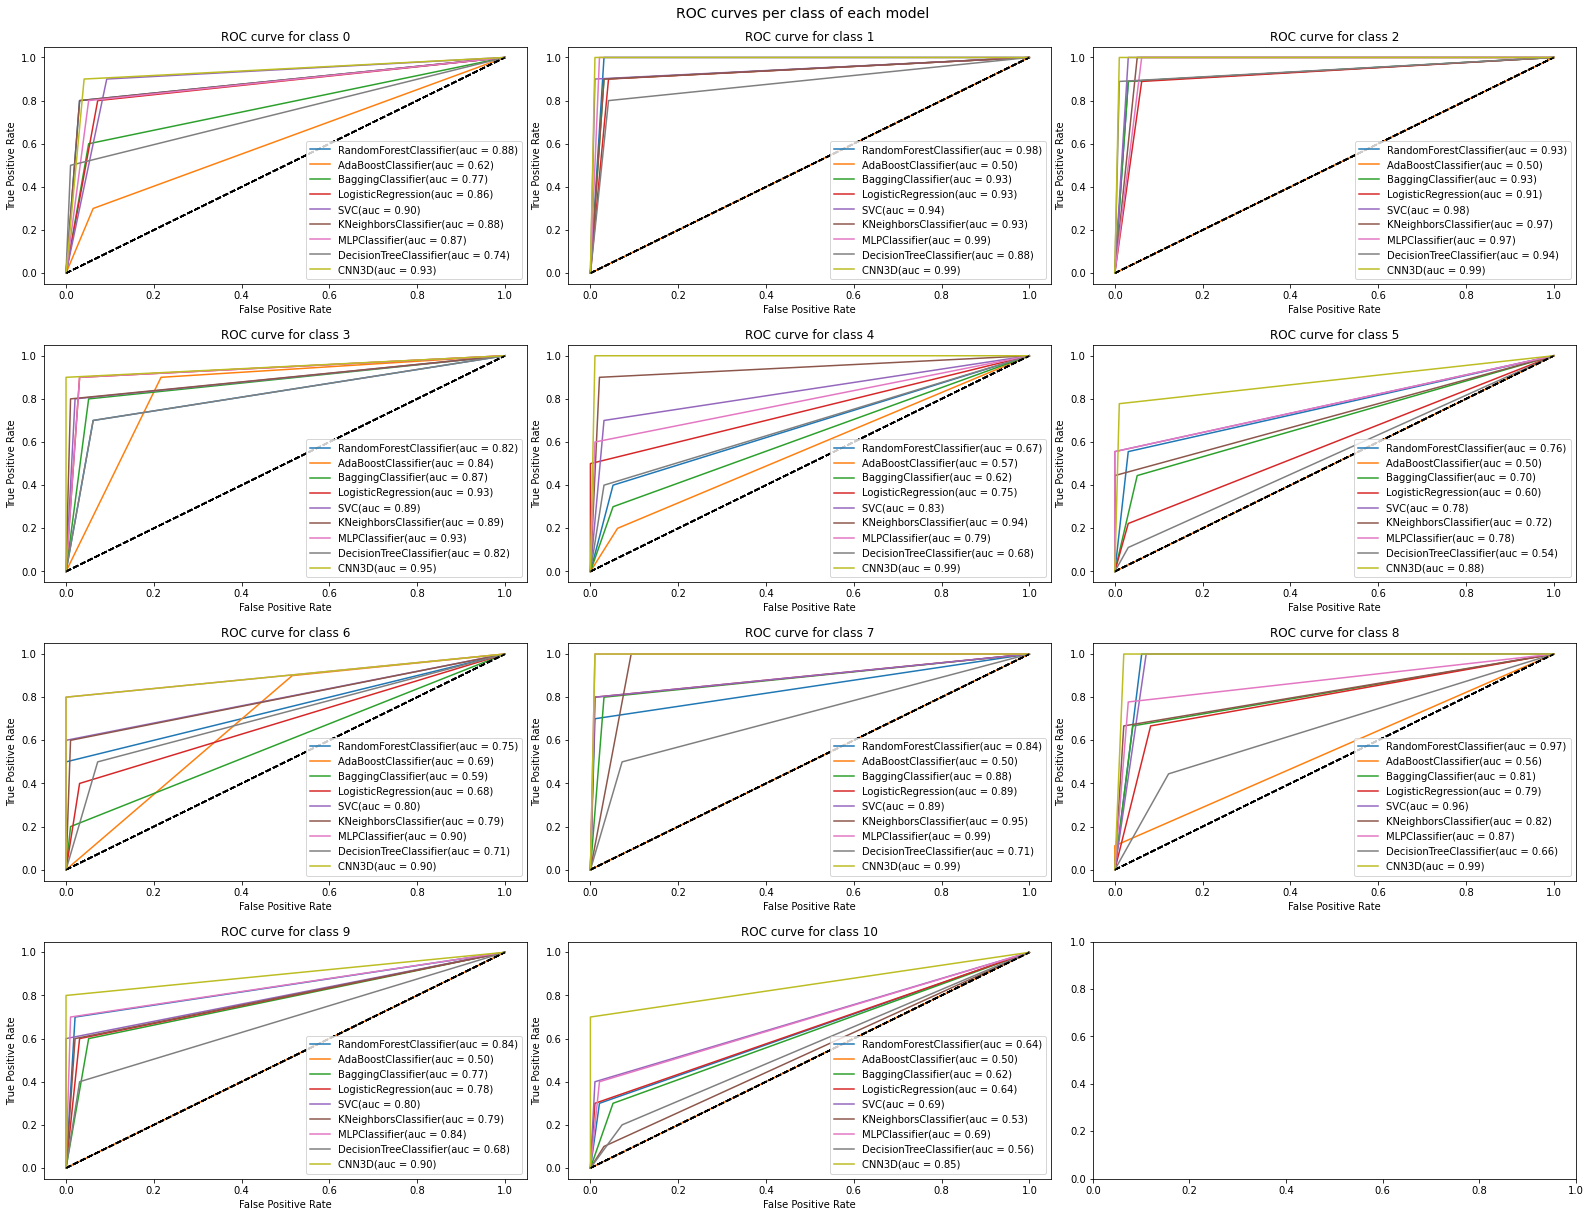

In [19]:
rows = 4
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(22, 17))

fig.suptitle('ROC curves per class of each model', fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.98], h_pad=4.0)

row = 0
col = 0
for i in range(n_classes):
    plot_ROC_curve(axes[row, col], **{'class': i, 'results': results, 'models': all_models})

    col += 1

    if col == cols:
        col = 0
        row += 1

#### Confusion Matrices plot

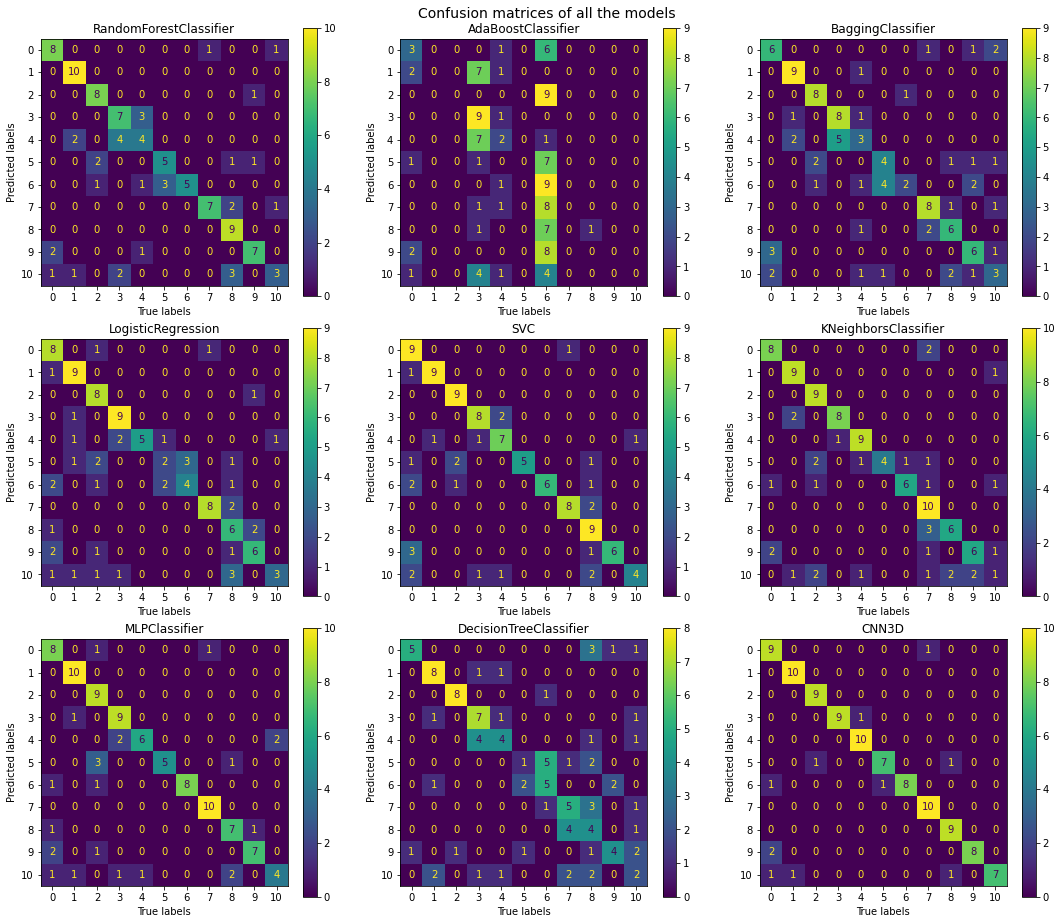

In [20]:
rows = 3
cols = len(results)//rows
fig, axes = plt.subplots(rows, cols, figsize=(15, 13))

fig.suptitle('Confusion matrices of all the models', fontsize=14)
fig.tight_layout(w_pad=2.0)


row = 0
col = 0
for i in range(len(results)):
    y_true = results[i][0]
    y_pred = results[i][1]
    
    model_name = type(all_models[i]).__name__
    if model_name is "Functional":
        model_name = all_models[i].name
    
    plot_confusion_matrix(y_true, y_pred, ax=axes[row, col], title=model_name)
    
    col += 1
      
    if col == cols:
        col = 0
        row += 1

#### Accuracies plots

In [21]:
cv_results = []
names = []

for i in range(len(results)):
    cv_results.append(results[i][-1])
    
    name = type(all_models[i]).__name__
    if name is "Functional":
        name = all_models[i].name
    names.append(name)

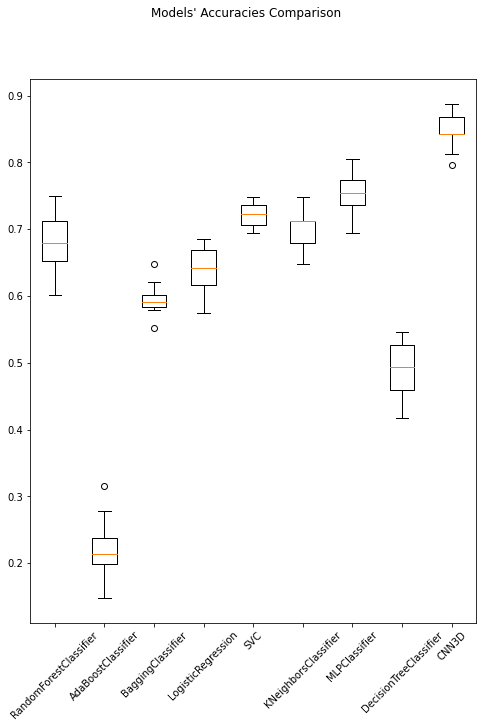

In [22]:
# boxplot models comparison
fig = plt.figure(figsize=(8,10))
fig.suptitle('Models\' Accuracies Comparison')
ax = fig.add_subplot(111)
plt.boxplot(cv_results)
ax.set_xticklabels(names)
plt.xticks(rotation=45)
plt.show()

### 4. Conclusions

Starting from this analysis, we select the best classifier according to:
1. the Area Under Curve (for all classes) 
2. the diagonality of the Confusion Matrix
3. the Cross-Validated accuracy on validation

From the plots above, it is clearly visible that **Conv3D** model outperforms the others. 
First, its ROC curves are much higher than the others in all classes, especially in those where other models struggle in predicting samples correctly. Its Areas Under Curve are equal to 1 almost everywhere. This accuracy reflects into Conv3D model's Confusion Matrix, which is the most diagonal among all the matrices. Lastly, the box-plot of Cross-Validated accuracies shows that the average accuracy (orange line) of Conv3D model on validation is even higher than the maximum accuracy achieved by all the other models. 

From now on, we will use this model to conduct further analyses. 

# 3. Comparison of different datasets

## a. Datasets visualization

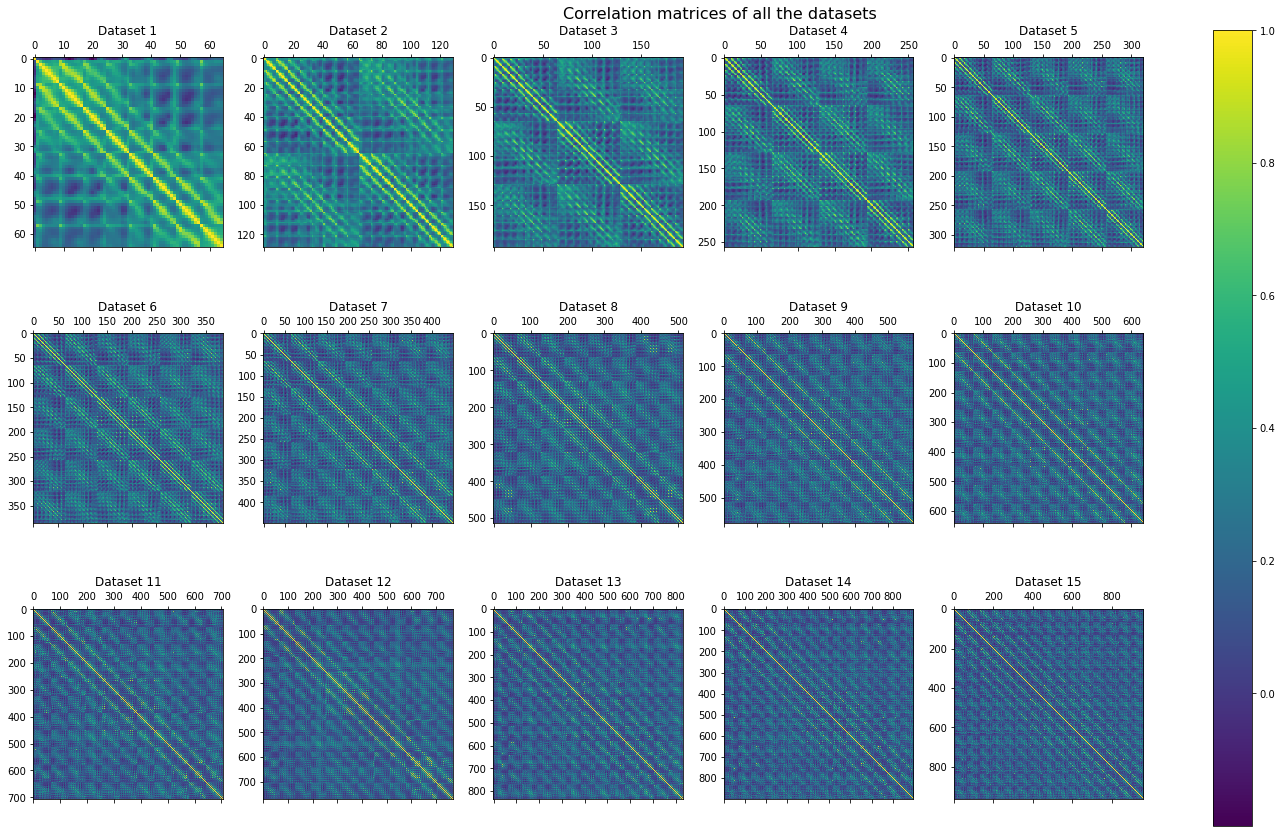

In [23]:
rows = 3
fig, axes = plt.subplots(rows, n_datasets//rows, figsize=(20, 12))

fig.suptitle('Correlation matrices of all the datasets', fontsize=16)
fig.tight_layout(w_pad=2.0)

dataset_number = 1
for row in range(rows):
    for col in range(n_datasets//rows):
        img = axes[row,col].matshow(train_datasets[dataset_number].corr())
        axes[row,col].title.set_text('Dataset ' + str(dataset_number));
        
        dataset_number += 1
        
fig.colorbar(img, ax=axes.ravel().tolist())

## b. Datasets comparison
We do a **t-test** between each sample of two different dataframes. To do that, we compare one by one all the dataframes with the main one.
In this way, we will be able to state how significant the expansion or the contraction of the slices is.

Null and alternative hypothesis are:
* **H0**: $\mu$<sub>i</sub> $ - \mu$<sub>j</sub> $=$ 0 (Samples *i* and *j* are identical)
* **H1**: $\mu$<sub>i</sub> $ - \mu$<sub>j</sub> $\neq$ 0 (Samples *i* and *j* are different)

We set $\alpha$ confidence level to 5%.

In [24]:
def t_test(df1, df2, alpha):   
    n_different_samples = 0          
    
    for i in range(df1.shape[0]):
        result, pvalue = ttest_ind(df1.loc[i,:], df2.loc[i,:]) 
        
        # Check if H0 is rejected
        if pvalue <= alpha:        
            n_different_samples += 1
            
    return n_different_samples

In [25]:
alpha = 0.05
datasets_ids = []
all_divergences = []

for i in train_datasets.keys():
    if i == main_ds:
        continue
        
    datasets_ids.append(i)
    n_divergences = t_test(main_train_df, train_datasets[i], alpha)
    all_divergences.append(n_divergences)

Here we show the number of significant different samples between the dataset with 5 slices and all the other datasets. Results come from the previous t-test analysis.

In [26]:
df = pd.DataFrame(np.array(all_divergences)/main_train_df.shape[0], columns=['difference ratio'], index=datasets_ids)
df.index.names = ['# slices']
df

,difference ratio
# slices,
1,0.828227
2,0.479109
3,0.155060
4,0.000000
6,0.000000
7,0.027855
8,0.232126
9,0.367688
10,0.463324


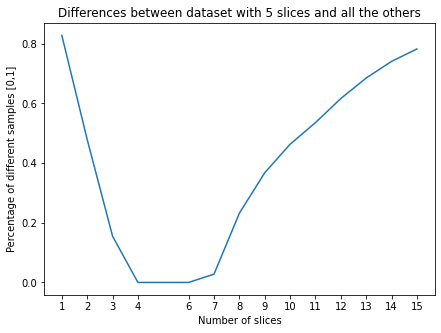

In [27]:
plt.figure(figsize=(7,5))
plt.plot(df.index, df['difference ratio'])
plt.xticks(df.index)
plt.title("Differences between dataset with %d slices and all the others" % main_ds)
plt.xlabel("Number of slices")
plt.ylabel("Percentage of different samples [0,1]")
plt.show()

## c. Training of the chosen model on the various datasets 
Here we won't use Cross-Validation since it would take too much time

In [28]:
dataset_results = []
train_times = []
test_times = []

for n_slices in train_datasets.keys():
    # Data preprocessing
    train_images, _ = dataframe_to_images(train_datasets[n_slices], n_slices=n_slices, n_features=n_features, preserve_shape=True)
    input_shape = train_images.shape[1:]
    
    X_train, X_valid, y_train, y_valid = split_dataset(train_images, train_datasets[n_slices].label, val_split=1./K)
    
    # Model training
    print("Training on slice %d" % n_slices)
    
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=PATIENCE, restore_best_weights=False)
    model = build_model(input_shape, n_classes)
    
    
    start = time.time()
    history = train_model(model=model, 
                          train_data=(X_train, y_train),
                          valid_data=(X_valid, y_valid),
                          optimizer=optimizer, 
                          callbacks=[early_stopping],
                          bs=BS,
                          epochs=EPOCHS,
                          verbose=False,
                          print_summary=False)
    elapsed_time = time.time() - start
    train_times.append(elapsed_time)
    
    print("Training ended. Time elapsed: %dm %ds" % (elapsed_time//60, elapsed_time%60))
    
    acc_t = history.history['accuracy'][-early_stopping.patience]
    acc_v = history.history['val_accuracy'][-early_stopping.patience]
    
    print("Accuracy on training: {:.2f}".format(acc_t))
    print("Accuracy on validation: {:.2f}\n\n".format(acc_v))
    
    start = time.time()
    y_pred = model.predict(X_valid) # compute the predictions on the validation set of the best split
    y_pred = np.argmax(y_pred, axis=1)
    test_times.append(time.time() - start)
    
    dataset_results.append((y_train.values, y_pred, acc_t, acc_v))

Training on slice 1
Epoch 00133: early stopping
Training ended. Time elapsed: 0m 55s
Accuracy on training: 0.76
Accuracy on validation: 0.70


Training on slice 2
Epoch 00105: early stopping
Training ended. Time elapsed: 1m 29s
Accuracy on training: 0.88
Accuracy on validation: 0.78


Training on slice 3
Epoch 00104: early stopping
Training ended. Time elapsed: 2m 13s
Accuracy on training: 0.90
Accuracy on validation: 0.87


Training on slice 4
Epoch 00108: early stopping
Training ended. Time elapsed: 3m 12s
Accuracy on training: 0.94
Accuracy on validation: 0.88


Training on slice 5
Epoch 00141: early stopping
Training ended. Time elapsed: 5m 4s
Accuracy on training: 0.97
Accuracy on validation: 0.89


Training on slice 6
Epoch 00066: early stopping
Training ended. Time elapsed: 2m 53s
Accuracy on training: 0.95
Accuracy on validation: 0.86


Training on slice 7
Epoch 00062: early stopping
Training ended. Time elapsed: 3m 9s
Accuracy on training: 0.93
Accuracy on validation: 0.87


T

## d. Results

### Training/validation times plot

Text(0, 0.5, 'Time [s]')

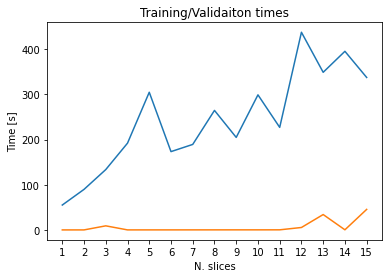

In [29]:
xticks = range(1, len(train_datasets)+1)

plt.plot(xticks, train_times, label="Train")
plt.plot(xticks, test_times, label="Valid")
plt.xticks(xticks)
plt.title("Training/Validaiton times")
plt.xlabel("N. slices")
plt.ylabel("Time [s]")

### Training/validation accuracies plot

Text(0, 0.5, 'Accuracy')

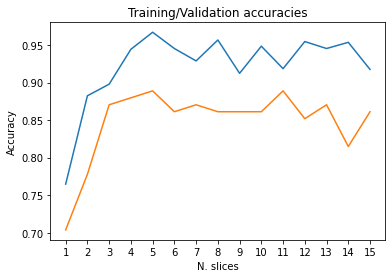

In [30]:
train_accuracies = [acc for _, _, acc, _ in dataset_results]
val_accuracies = [acc for _, _, _, acc in dataset_results]

plt.plot(xticks, train_accuracies, label="Train")
plt.plot(xticks, val_accuracies, label="Valid")
plt.xticks(xticks)
plt.title("Training/Validation accuracies")
plt.xlabel("N. slices")
plt.ylabel("Accuracy")

# 4. Final solution
Since the other datasets showed some interesting differences with the main one, we now want to use them to augment the main dataset. \
To do so, we concatenate the DataFrames one on top of the other. \
The choice of the datasets to use has been made basing on the results of the t-test analysis. 

## a. Data preparation

In [31]:
# Split main dataset
train_images, _ = dataframe_to_images(main_train_df, n_slices=main_ds, n_features=n_features)
X_train, X_valid, y_train, y_valid = split_dataset(train_images, labels)

# Split dataset with 6 slices
train_images, _ = dataframe_to_images(train_datasets[6], n_slices=main_ds, n_features=n_features)
X_train_, X_valid_, y_train_, y_valid_ = split_dataset(train_images, labels)

# Concatenate splits together (training with training, validation with validation)
X_train = np.concatenate((X_train, X_train_))
X_valid = np.concatenate((X_valid, X_valid_))
y_train = np.concatenate((y_train, y_train_))
y_valid = np.concatenate((y_valid, y_valid_))

## b. Retraining of chosen model

Model: "CNN3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 8, 8, 1)]      0         
_________________________________________________________________
block1_conv1 (Conv3D)        (None, 5, 8, 8, 64)       1792      
_________________________________________________________________
dropout (Dropout)            (None, 5, 8, 8, 64)       0         
_________________________________________________________________
block1_conv2 (Conv3D)        (None, 5, 8, 8, 64)       110656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 8, 8, 64)       0         
_________________________________________________________________
block1_pool (MaxPooling3D)   (None, 2, 4, 4, 64)       0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0     

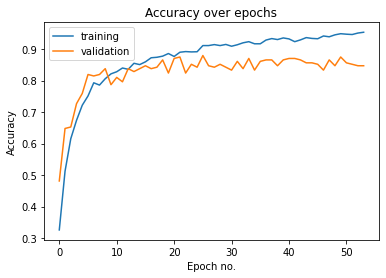

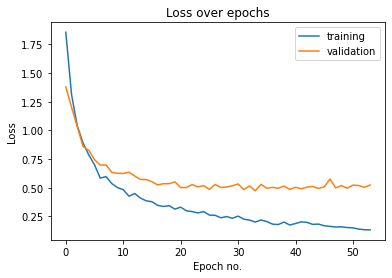

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=PATIENCE, restore_best_weights=True)
input_shape = train_images.shape[1:]

# Build the model
model = build_model(input_shape, n_classes)

# Train the model
history = train_model(model=model, 
                      train_data=(X_train, y_train),
                      valid_data=(X_valid, y_valid),
                      optimizer = optimizer,
                      callbacks=[early_stopping],
                      bs=BS,
                      epochs=EPOCHS,
                      verbose=True,
                      print_summary=True)

plot_accuracy(history)
plot_loss(history)

### Notes
The accuracy plot shows a higher validation accuracy (and a lower loss) than the training one for the first epochs. This is due to the presence of Dropout layers, that "turn off" some neurons during the training, while they turn them on again for testing. Hence, since less features are used during training, accuracy may be higher than the one on validation, that is what happens in our case.

## b. Predictions on the test set

In [33]:
predictions = model.predict(test_images)
predictions = np.argmax(predictions, axis=1)

## c. Final .csv file creation

In [34]:
pred_df = pd.DataFrame(predictions, index = range(len(predictions)), columns=["label"])
pred_df.index.name = "id"
pred_df

,label
id,
0,5
1,4
2,6
3,7
4,3
...,...
259,0
260,3
261,9


In [35]:
OUT_DIR = "/kaggle/working"
CSV_NAME = "submission.csv"

os.chdir(OUT_DIR)
pred_df.to_csv(CSV_NAME)
FileLink(CSV_NAME)

/kaggle/working/submission.csv